# Referenced and rewritten from [Automated Hate Speech Detection and the Problem of Offensive Language.ipynb](https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/src/Automated%20Hate%20Speech%20Detection%20and%20the%20Problem%20of%20Offensive%20Language.ipynb)

## Install project dependencies

In [122]:
!pip install vaderSentiment
!pip install textstat
!pip install flwr

In [123]:
import pandas as pd
import numpy as np
import pickle
import sys
import string
import re
import nltk
import matplotlib.pyplot as plt
import seaborn
import flwr as fl
import os
import warnings
import multiprocessing as mp
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from typing import Tuple, Union, List, Dict
from google.colab import drive
%matplotlib inline

## Mounting external storage

In [124]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the data

In [125]:
df = pd.read_pickle(open("/content/drive/MyDrive/COMP0029/labeled_data.p", mode='rb'))

In [126]:
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [127]:
df.describe()

,count,hate_speech,offensive_language,neither
count,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247
std,0.883060,0.631851,1.399459,1.113299
min,3.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000
50%,3.000000,0.000000,3.000000,0.000000
75%,3.000000,0.000000,3.000000,0.000000
max,9.000000,7.000000,9.000000,9.000000


In [128]:
df.columns

Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet'],
      dtype='object')

### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


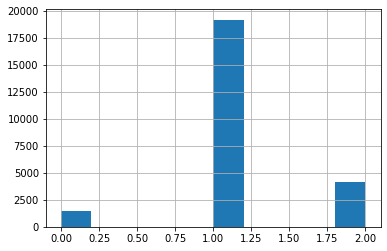

In [129]:
df['class'].hist()

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

In [130]:
tweets=df.tweet

## Feature generation

In [131]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [132]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names_out())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  % sorted(inconsistent)


In [133]:
nltk.download('averaged_perceptron_tagger')
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [134]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [135]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names_out())}

In [136]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [137]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [138]:
feats = get_feature_array(tweets)

In [139]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [140]:
M.shape

(24783, 4023)

In [141]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

# Running the model

In [142]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [143]:
feature_transformer = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1", C=0.01, solver='liblinear'))

X_ = feature_transformer.fit_transform(X,y)

In [144]:
X_.shape

(24783, 466)

In [145]:
classifier = LogisticRegression(class_weight='balanced',penalty='l2', C=0.01, solver='liblinear')

In [146]:
model = classifier.fit(X_, y)

In [147]:
y_preds = model.predict(X_)

## Evaluating the results

In [148]:
report = classification_report( y, y_preds )

In [149]:
print(report)

              precision    recall  f1-score   support

           0       0.42      0.54      0.47      1430
           1       0.94      0.89      0.91     19190
           2       0.71      0.84      0.77      4163

    accuracy                           0.86     24783
   macro avg       0.69      0.75      0.72     24783
weighted avg       0.87      0.86      0.86     24783



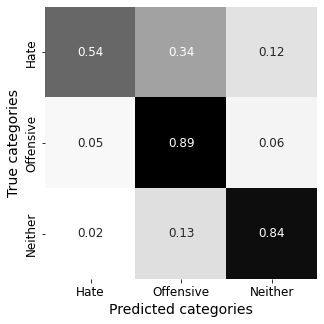

In [150]:
confusion_matrix = confusion_matrix(y,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

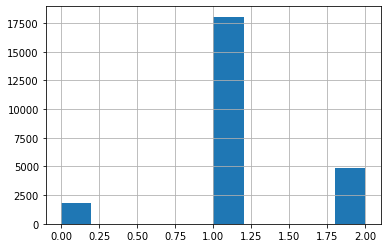

In [151]:
#Distribution of estimates
pd.Series(y_preds).hist()

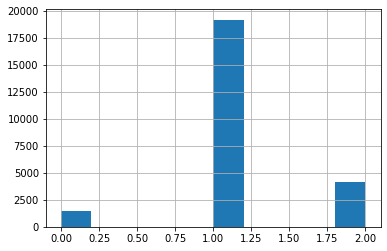

In [152]:
#True distribution
y.hist()

# Federating The Model

Single-machine simulation of a federated learning system using Flower

## Utility Functions

In [153]:
XY = Tuple[np.ndarray, np.ndarray]
Dataset = Tuple[XY, XY]
LogRegParams = Union[XY, Tuple[np.ndarray]]
XYList = List[XY]


def get_model_parameters(model: LogisticRegression) -> LogRegParams:
#Returns the paramters of a sklearn LogisticRegression model.
    if model.fit_intercept:
        params = (model.coef_, model.intercept_)
    else:
        params = (model.coef_,)
    return params


def set_model_params(
    model: LogisticRegression, params: LogRegParams
) -> LogisticRegression:
#Sets the parameters of a sklean LogisticRegression model.
    model.coef_ = params[0]
    if model.fit_intercept:
        model.intercept_ = params[1]
    return model


def set_initial_params(model: LogisticRegression):
#Sets initial parameters as zeros Required since model params are
#uninitialized until model.fit is called.
#But server asks for initial parameters from clients at launch. Refer
#to sklearn.linear_model.LogisticRegression documentation for more
#information.

    n_classes = 3  # our dataset has 3 classes
    n_features = 466  # Number of features in dataset after feature selection by transformer
    model.classes_ = np.array([i for i in range(n_classes)])

    model.coef_ = np.zeros((n_classes, n_features))
    if model.fit_intercept:
        model.intercept_ = np.zeros((n_classes,))

def load_dataset() -> Dataset:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    return (X_train, y_train), (X_test, y_test)

def partition(X: np.ndarray, y: np.ndarray, num_partitions: int) -> XYList:
# Split X and y into a number of partitions.
    return list(
        zip(np.array_split(X, num_partitions), np.array_split(y, num_partitions))
    )

## Server API

In [154]:
def fit_round(rnd: int) -> Dict:
    """Send round number to client."""
    return {"rnd": rnd}


def get_eval_fn(model: LogisticRegression):
    """Return an evaluation function for server-side evaluation."""

    # Load test data here to avoid the overhead of doing it in `evaluate` itself
    _, (X_test, y_test) = load_dataset()

    # Select features
    X_test_ = feature_transformer.transform(X_test)

    # The `evaluate` function will be called after every round
    def evaluate(parameters: fl.common.Weights):
        # Update model with the latest parameters
        set_model_params(model, parameters)
        loss = log_loss(y_test, model.predict_proba(X_test_))
        accuracy = model.score(X_test_, y_test)
        return loss, {"accuracy": accuracy}

    return evaluate

In [155]:
def start_flower_server():
  print('module name:', __name__)
  print('parent process:', os.getppid())
  print('process id:', os.getpid())

  model = LogisticRegression()
  set_initial_params(model)
  strategy = fl.server.strategy.FedAvg(
        min_available_clients=2,
        eval_fn=get_eval_fn(model),
        on_fit_config_fn=fit_round,
  )
  fl.server.start_server("0.0.0.0:80", strategy=strategy, config={"num_rounds": 5})

## Client API

In [156]:
def start_flower_client(X_train_: np.ndarray, y_train: np.ndarray, X_test_: np.ndarray, y_test: np.ndarray):
  print('module name:', __name__)
  print('parent process:', os.getppid())
  print('process id:', os.getpid())

  # Create LogisticRegression Model
  # max_iter: local epoch, warm_start: prevent refreshing weights when fitting
  model = LogisticRegression(penalty='l2', max_iter=1, warm_start=True, class_weight='balanced', C=0.01, multi_class='ovr') 

  # Setting initial parameters, akin to model.compile for keras models
  set_initial_params(model)

  # Define Flower client
  class MnistClient(fl.client.NumPyClient):
    def get_parameters(self): # type: ignore
      return get_model_parameters(model)

    def fit(self, parameters, config):  # type: ignore
      set_model_params(model, parameters)
      # Ignore convergence failure due to low local epochs
      with warnings.catch_warnings():
          warnings.simplefilter("ignore")
          model.fit(X_train_, y_train)
      print(f"Training finished for round {config['rnd']}")
      return get_model_parameters(model), len(X_train_), {}

    def evaluate(self, parameters, config):  # type: ignore
      set_model_params(model, parameters)
      loss = log_loss(y_test, model.predict_proba(X_test_))
      accuracy = model.score(X_test_, y_test)
      return loss, len(X_test_), {"accuracy": accuracy}

  # Start Flower client
  fl.client.start_numpy_client("0.0.0.0:80", client=MnistClient())

In [157]:
def start_flower_clients(number_of_clients):
  # Load dataset
  (X_train, y_train), (X_test, y_test) = load_dataset()

  # Select features
  X_train_ = feature_transformer.transform(X_train)
  X_test_ = feature_transformer.transform(X_test)

  # Split train set into number_of_clients partitions.
  partitioned_train_set = partition(X_train_, y_train, number_of_clients)

  for i in range(number_of_clients):
    (X_train_partition, y_train_partition) = partitioned_train_set[i]
    p = mp.Process(target=start_flower_client, args=(X_train_partition, y_train_partition, X_test_, y_test))
    p.start()


In [158]:
# Start Flower server for five rounds of federated learning
server = mp.Process(target=start_flower_server)
server.start()

# Start 2 Flower clients to participate
start_flower_clients(2)

# Wait for rounds of federated learning to finish
server.join()

module name: __main__
parent process: 61
process id: 2865


INFO flower 2021-12-17 01:45:08,310 | app.py:80 | Flower server running (insecure, 5 rounds)
INFO flower 2021-12-17 01:45:08,315 | server.py:118 | Initializing global parameters
INFO flower 2021-12-17 01:45:08,319 | server.py:304 | Requesting initial parameters from one random client


module name: __main__
module name: __main__
parent process: 61
parent process: 61
process id: 2884
process id: 2887


DEBUG flower 2021-12-17 01:45:08,803 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2021-12-17 01:45:08,807 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2021-12-17 01:45:08,821 | connection.py:36 | ChannelConnectivity.READY
DEBUG flower 2021-12-17 01:45:08,827 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2021-12-17 01:45:08,810 | app.py:61 | Opened (insecure) gRPC connection
INFO flower 2021-12-17 01:45:08,819 | app.py:61 | Opened (insecure) gRPC connection
INFO flower 2021-12-17 01:45:08,846 | server.py:307 | Received initial parameters from one random client
INFO flower 2021-12-17 01:45:08,850 | server.py:120 | Evaluating initial parameters
INFO flower 2021-12-17 01:45:08,893 | server.py:127 | initial parameters (loss, other metrics): 1.0986122886681096, {'accuracy': 0.06212182331585317}
INFO flower 2021-12-17 01:45:08,900 | server.py:133 | FL starting
DEBUG flower 2021-12-17 01:45:08,908 | server.py:255 | fit_round: strategy sampled 2 clients 

Training finished for round 1
Training finished for round 1


DEBUG flower 2021-12-17 01:45:09,551 | server.py:264 | fit_round received 2 results and 0 failures
INFO flower 2021-12-17 01:45:09,593 | server.py:154 | fit progress: (1, 1.1597132852747434, {'accuracy': 0.3892698668818072}, 0.6849718350003968)
INFO flower 2021-12-17 01:45:09,604 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2021-12-17 01:45:09,611 | server.py:255 | fit_round: strategy sampled 2 clients (out of 2)


Training finished for round 2
Training finished for round 2


DEBUG flower 2021-12-17 01:45:09,972 | server.py:264 | fit_round received 2 results and 0 failures
INFO flower 2021-12-17 01:45:10,027 | server.py:154 | fit progress: (2, 1.0509363461518098, {'accuracy': 0.573215006050827}, 1.1192731680002908)
INFO flower 2021-12-17 01:45:10,036 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2021-12-17 01:45:10,044 | server.py:255 | fit_round: strategy sampled 2 clients (out of 2)


Training finished for round 3
Training finished for round 3


DEBUG flower 2021-12-17 01:45:10,427 | server.py:264 | fit_round received 2 results and 0 failures
INFO flower 2021-12-17 01:45:10,472 | server.py:154 | fit progress: (3, 1.0142053532027944, {'accuracy': 0.5623235175473982}, 1.5641064009996626)
INFO flower 2021-12-17 01:45:10,487 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2021-12-17 01:45:10,494 | server.py:255 | fit_round: strategy sampled 2 clients (out of 2)


Training finished for round 4
Training finished for round 4


DEBUG flower 2021-12-17 01:45:10,910 | server.py:264 | fit_round received 2 results and 0 failures
INFO flower 2021-12-17 01:45:10,950 | server.py:154 | fit progress: (4, 1.0262327457460734, {'accuracy': 0.5780556676079064}, 2.042501469999479)
INFO flower 2021-12-17 01:45:10,963 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2021-12-17 01:45:10,967 | server.py:255 | fit_round: strategy sampled 2 clients (out of 2)


Training finished for round 5
Training finished for round 5


DEBUG flower 2021-12-17 01:45:11,334 | server.py:264 | fit_round received 2 results and 0 failures
INFO flower 2021-12-17 01:45:11,376 | server.py:154 | fit progress: (5, 0.99276274658513, {'accuracy': 0.6127470754336426}, 2.4682110489993647)
INFO flower 2021-12-17 01:45:11,387 | server.py:199 | evaluate_round: no clients selected, cancel
INFO flower 2021-12-17 01:45:11,396 | server.py:172 | FL finished in 2.488474937999854
INFO flower 2021-12-17 01:45:11,406 | app.py:119 | app_fit: losses_distributed []
INFO flower 2021-12-17 01:45:11,413 | app.py:120 | app_fit: metrics_distributed {}
INFO flower 2021-12-17 01:45:11,419 | app.py:121 | app_fit: losses_centralized [(0, 1.0986122886681096), (1, 1.1597132852747434), (2, 1.0509363461518098), (3, 1.0142053532027944), (4, 1.0262327457460734), (5, 0.99276274658513)]
INFO flower 2021-12-17 01:45:11,425 | app.py:122 | app_fit: metrics_centralized {'accuracy': [(0, 0.06212182331585317), (1, 0.3892698668818072), (2, 0.573215006050827), (3, 0.5623